In [0]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My Drive/datasets/DCGAN

/content/gdrive/My Drive/datasets/DCGAN


In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
from keras import initializers
import os
import keras
from keras import layers
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
X_train = X_train[y_train.flatten() == 3]

In [3]:
# figure를 plt로 visualize
def visualize_rgb(img):
    """
    Visualize a rgb image
    :param img: RGB image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


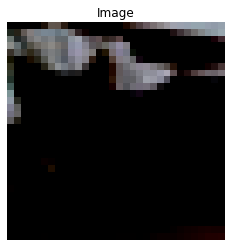

In [17]:
visualize_rgb(X_train[0])

In [5]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)   # img shape을 튜플로 고정     
latent_dim = 100  # 이미지 레이어의 잡음 공간

In [6]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)
#표준편차가0인 값으로 세팅

# Generator network
generator = Sequential()

# FC: 2x2x512
# input - 100 --> 2*2*512 의 뉴런 출력
generator.add(Dense(2*2*512, input_shape=(latent_dim,), activation='relu', kernel_initializer=init))
generator.add(BatchNormalization())
generator.add(Reshape((2, 2, 512)))
# 2*2 featuremap 512개

# # Conv 1: (2,2,512) -> 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
# 
generator.add(BatchNormalization())

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())


# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())

# Conv 4: 32x32x3 결국 마지막 conv4에서 매핑이 되는 타입으로 변경
generator.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same',kernel_initializer=init,
                              activation='tanh'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         1179904   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)        

In [8]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=3, strides=2, use_bias=False, padding='valid',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))


# Conv 2:
discriminator.add(Conv2D(128, kernel_size=3, strides=2,  kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=3, strides=2, kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# discriminator.add(Flatten())
discriminator.add(GlobalAveragePooling2D())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [9]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 64)        1728      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73728     
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 256)        

In [10]:
# Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z) # 잡음이 generate를 통과하면 fake가 생성

decision = discriminator(img)
gan_model = Model(inputs=z, outputs=decision)

gan_model.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [12]:
def normalize(img):
    return (img - 127.5) / 127.5

In [13]:
# 255를 넘어가면 전부 255로 치부
def denormalize(img):
    img = (img * 127.5) + 127.5
    return img.astype(np.uint8)

In [14]:
print(X_train.shape)

(5000, 32, 32, 3)


In [15]:
# 데이터를 정규화합니다
X_train = normalize(X_train)

iterations = 5000
batch_size = 20
save_dir = os.path.join("./", 'gan_images')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [16]:
epochs = 5000
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
                                                # SMOOTH 는 잡음을 섞어줌(그로 인해 네트워크가 좀더 강한 성능을 낼 수 있다)
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = gan_model.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 3 == 0:
      gan_model.save_weights('gan.h5')

      img = image.array_to_img(denormalize(X_fake[0]), scale=False)
      img.save(os.path.join(save_dir, 'generated' + str(e) + '.png'))

      img = image.array_to_img(denormalize(X_batch[0]), scale=False)
      img.save(os.path.join(save_dir, 'real' + str(e) + '.png'))
       


epoch = 1/5000, d_loss=0.492, g_loss=0.163                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 5/5000, d_loss=1.287, g_loss=0.922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
epoch = 6/5000, d_loss=1.293, g_loss=0.896                                                                                                                                                                                                 

epoch = 9/5000, d_loss=1.338, g_loss=0.931                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

epoch = 12/5000, d_loss=1.288, g_loss=0.887                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 15/5000, d_loss=1.310, g_loss=0.879                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 18/5000, d_loss=1.365, g_loss=0.905                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 22/5000, d_loss=1.309, g_loss=0.919                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 25/5000, d_loss=1.369, g_loss=0.917                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 29/5000, d_loss=1.322, g_loss=0.955                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 33/5000, d_loss=1.166, g_loss=0.895                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 36/5000, d_loss=1.217, g_loss=0.991                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 38/5000, d_loss=1.220, g_loss=0.976                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 40/5000, d_loss=1.240, g_loss=0.890                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 44/5000, d_loss=1.234, g_loss=0.973                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 51/5000, d_loss=1.208, g_loss=1.090                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 58/5000, d_loss=1.083, g_loss=1.050                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 64/5000, d_loss=1.040, g_loss=1.118                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 73/5000, d_loss=0.936, g_loss=1.108                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
epoch = 74/5000, d_loss=0.932, g_loss=1.125                                                                                          

epoch = 78/5000, d_loss=1.064, g_loss=1.132                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
epoch = 79/5000, d_loss=1.088, g_loss=1.120                                                                                           

epoch = 85/5000, d_loss=1.038, g_loss=1.253                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 89/5000, d_loss=1.020, g_loss=1.432                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 93/5000, d_loss=0.917, g_loss=1.130                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 98/5000, d_loss=1.094, g_loss=1.242                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

epoch = 101/5000, d_loss=0.899, g_loss=1.245                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 106/5000, d_loss=0.878, g_loss=1.221                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 109/5000, d_loss=0.930, g_loss=1.278                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 113/5000, d_loss=0.759, g_loss=1.504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 114/5000, d_loss=0.815, g_loss=1.268                                                                                                                                                                                            

epoch = 121/5000, d_loss=0.843, g_loss=1.446                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 127/5000, d_loss=0.858, g_loss=1.320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 133/5000, d_loss=1.060, g_loss=1.362                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 142/5000, d_loss=0.996, g_loss=1.239                                                                                                                                                                                                                           
epoch = 143/5000, d_loss=0.790, g_loss=1.444                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

epoch = 149/5000, d_loss=0.783, g_loss=1.965                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 154/5000, d_loss=0.924, g_loss=1.787                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 155/5000, d_loss=0.720,

epoch = 163/5000, d_loss=0.636, g_loss=1.797                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 170/5000, d_loss=0.807, g_loss=1.577                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 177/5000, d_loss=0.803, g_loss=1.485                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 178/5000, d_loss=0.677, g_loss=1.580                                                                                                                                                                                                                                                                                                  

epoch = 186/5000, d_loss=0.751, g_loss=1.534                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 187/5000, d_loss=0.670, g_loss=1.956                                                                                                                                                                                                                                                                                                 

epoch = 195/5000, d_loss=0.971, g_loss=1.466                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 203/5000, d_loss=0.823, g_loss=1.748                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 204/5000, d_loss=0.650, g_loss=1.953                                                                                                                                                                                                                                                                                                                                                                                                       

epoch = 213/5000, d_loss=0.715, g_loss=1.654                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 222/5000, d_loss=0.693, g_loss=1.950                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 227/5000, d_loss=0.570, g_loss=2.202                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 228/5000, d_loss=0.683, g_loss=2.236                                                                                                                                                                                            

epoch = 237/5000, d_loss=0.554, g_loss=2.009                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
epoch = 238/5000, d_loss=0.537, g_loss=2.783                                                                                        

epoch = 246/5000, d_loss=0.822, g_loss=2.071                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 247/5000, d_loss=0.687, g_loss=1.920                                                                                                                                                                                                                                                                                                  

epoch = 256/5000, d_loss=0.571, g_loss=2.443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 257/5000, d_loss=0.689, g_loss=2.307                                                                                       

epoch = 262/5000, d_loss=0.500, g_loss=2.147                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 266/5000, d_loss=0.513, g_loss=2.170                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 275/5000, d_loss=0.491, g_loss=2.250                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 281/5000, d_loss=0.549, g_loss=2.221                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 287/5000, d_loss=0.589, g_loss=2.721                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 288/5000, d_loss=0.684, g_loss=2.017                                                                                       

epoch = 292/5000, d_loss=0.559, g_loss=2.384                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 295/5000, d_loss=0.489, g_loss=2.767                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 300/5000, d_loss=0.453, g_loss=2.270                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 305/5000, d_loss=0.539, g_loss=2.731                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 306/5000, d_loss=0.489, g_loss=2.898                                                                                                                                                                                            

epoch = 311/5000, d_loss=0.585, g_loss=2.414                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 317/5000, d_loss=0.640, g_loss=2.785                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 324/5000, d_loss=0.468, g_loss=2.551                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 327/5000, d_loss=0.419, g_loss=3.032                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 331/5000, d_loss=0.520, g_loss=2.668                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 336/5000, d_loss=0.521, g_loss=3.164                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 341/5000, d_loss=0.451, g_loss=2.751                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 342/5000, d_loss=0.510,

epoch = 347/5000, d_loss=0.557, g_loss=2.381                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 352/5000, d_loss=0.675, g_loss=2.156                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 356/5000, d_loss=0.521, g_loss=2.546                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 361/5000, d_loss=0.565, g_loss=1.947                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 366/5000, d_loss=0.523, g_loss=3.271                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 369/5000, d_loss=0.463, g_loss=2.318                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 373/5000, d_loss=0.534, g_loss=2.742                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 378/5000, d_loss=0.528, g_loss=2.420                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 383/5000, d_loss=0.541, g_loss=1.858                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 388/5000, d_loss=0.547, g_loss=2.180                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 392/5000, d_loss=0.501, g_loss=1.556                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 397/5000, d_loss=0.471, g_loss=2.606                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 402/5000, d_loss=0.409, g_loss=1.207                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 406/5000, d_loss=0.469, g_loss=3.035                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 410/5000, d_loss=0.849, g_loss=1.545                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 414/5000, d_loss=0.402, g_loss=1.865                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 419/5000, d_loss=0.384, g_loss=3.148                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 423/5000, d_loss=0.449, g_loss=2.996                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 427/5000, d_loss=0.495, g_loss=2.770                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 431/5000, d_loss=0.461, g_loss=2.220                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 434/5000, d_loss=0.861, g_loss=1.073                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 439/5000, d_loss=0.631, g_loss=2.332                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 443/5000, d_loss=0.414, g_loss=3.392                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 448/5000, d_loss=0.615, g_loss=2.538                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 453/5000, d_loss=0.551, g_loss=2.432                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 458/5000, d_loss=0.460, g_loss=2.467                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 462/5000, d_loss=0.373, g_loss=1.170                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 467/5000, d_loss=0.412, g_loss=3.298                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 471/5000, d_loss=0.434, g_loss=2.539                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 475/5000, d_loss=0.517, g_loss=2.515                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 479/5000, d_loss=0.637, g_loss=2.997                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 483/5000, d_loss=0.513, g_loss=2.674                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 487/5000, d_loss=0.414, g_loss=3.013                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 491/5000, d_loss=0.438, g_loss=3.150                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 495/5000, d_loss=0.482, g_loss=3.125                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 499/5000, d_loss=0.426, g_loss=3.174                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 503/5000, d_loss=0.688, g_loss=0.894                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 507/5000, d_loss=0.475, g_loss=2.515                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 511/5000, d_loss=0.495, g_loss=2.961                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 519/5000, d_loss=0.403, g_loss=3.607                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 524/5000, d_loss=0.365, g_loss=3.745                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 526/5000, d_loss=0.470, g_loss=3.416                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 531/5000, d_loss=0.478, g_loss=2.652                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 534/5000, d_loss=0.424, g_loss=2.812                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 543/5000, d_loss=0.450, g_loss=2.756                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 544/5000, d_loss=0.420

epoch = 552/5000, d_loss=0.553, g_loss=2.469                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 555/5000, d_loss=0.488, g_loss=2.976                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 563/5000, d_loss=0.392, g_loss=3.058                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
epoch = 564/5000, d_loss=0.577, g_loss=2.626                                                                                                                                                                                             

epoch = 575/5000, d_loss=0.443, g_loss=2.796                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 581/5000, d_loss=0.415, g_loss=3.290                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 587/5000, d_loss=0.390, g_loss=3.737                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 592/5000, d_loss=0.782, g_loss=1.741                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 596/5000, d_loss=0.636, g_loss=2.766                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 604/5000, d_loss=0.468, g_loss=2.675                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 611/5000, d_loss=0.616, g_loss=2.878                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 616/5000, d_loss=0.443, g_loss=2.558                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 619/5000, d_loss=0.444, g_loss=3.113                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 622/5000, d_loss=0.404, g_loss=3.822                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 624/5000, d_loss=0.377, g_loss=2.435                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 627/5000, d_loss=0.361, g_loss=2.424                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 628/5000, d_loss=0.373, g_loss=3.041                                                                                                                                                                                                                                                                                                 

epoch = 631/5000, d_loss=0.453, g_loss=3.491                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 634/5000, d_loss=0.398, g_loss=3.517                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 636/5000, d_loss=0.788, g_loss=2.561                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 640/5000, d_loss=0.451, g_loss=3.143                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 644/5000, d_loss=0.426, g_loss=3.784                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 649/5000, d_loss=0.393, g_loss=4.163                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 654/5000, d_loss=0.400, g_loss=3.043                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 657/5000, d_loss=0.392, g_loss=2.215                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 660/5000, d_loss=0.782, g_loss=1.334                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 661/5000, d_loss=0.612

epoch = 663/5000, d_loss=0.391, g_loss=1.803                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 665/5000, d_loss=0.406, g_loss=3.694                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 668/5000, d_loss=0.420, g_loss=3.646                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 671/5000, d_loss=0.454, g_loss=2.350                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 675/5000, d_loss=0.408, g_loss=3.607                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 679/5000, d_loss=0.411, g_loss=2.993                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 682/5000, d_loss=0.456, g_loss=2.294                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 685/5000, d_loss=0.368, g_loss=4.285                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 688/5000, d_loss=0.433, g_loss=3.835                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 691/5000, d_loss=0.376, g_loss=3.582                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 694/5000, d_loss=0.425, g_loss=2.986                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 697/5000, d_loss=0.377, g_loss=3.517                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 701/5000, d_loss=0.419, g_loss=3.572                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 706/5000, d_loss=0.447, g_loss=3.151                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
epoch = 707/5000, d_loss=0.520, g_loss=2.979                                                                                                                                                                                             

epoch = 712/5000, d_loss=0.431, g_loss=4.277                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 717/5000, d_loss=0.428, g_loss=3.060                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 724/5000, d_loss=0.424, g_loss=2.810                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 729/5000, d_loss=0.445, g_loss=4.098                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 737/5000, d_loss=0.392, g_loss=2.756                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 744/5000, d_loss=0.467, g_loss=2.460                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 747/5000, d_loss=0.449, g_loss=2.798                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 751/5000, d_loss=0.525, g_loss=2.528                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 756/5000, d_loss=0.392, g_loss=2.623                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 764/5000, d_loss=0.520, g_loss=3.293                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 769/5000, d_loss=0.445, g_loss=3.381                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 773/5000, d_loss=0.455, g_loss=3.790                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 781/5000, d_loss=0.359, g_loss=3.238                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 788/5000, d_loss=0.413, g_loss=3.337                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
epoch = 789/5000, d_loss=0.384, g_loss=2.544                                                                                                                                                                                             

epoch = 796/5000, d_loss=0.739, g_loss=2.299                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 797/5000, d_loss=0.434, g_loss=2.934                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 803/5000, d_loss=0.395, g_loss=3.247                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 807/5000, d_loss=0.451, g_loss=3.221                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 808/5000, d_loss=0.410, g_loss=2.735                                                                                                                                                                                                                                                                                                 

epoch = 814/5000, d_loss=0.389, g_loss=3.544                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 820/5000, d_loss=0.376, g_loss=4.095                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 826/5000, d_loss=0.419, g_loss=4.929                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 829/5000, d_loss=0.467, g_loss=4.507                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 832/5000, d_loss=0.339, g_loss=4.859                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 835/5000, d_loss=0.386, g_loss=3.494                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 839/5000, d_loss=0.357, g_loss=3.242                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 840/5000, d_loss=0.356,

epoch = 842/5000, d_loss=0.348, g_loss=4.627                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 847/5000, d_loss=0.708, g_loss=4.286                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 851/5000, d_loss=0.451, g_loss=2.459                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 856/5000, d_loss=0.530, g_loss=2.300                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 862/5000, d_loss=0.385, g_loss=3.236                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 866/5000, d_loss=0.364, g_loss=3.214                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 870/5000, d_loss=0.372, g_loss=2.900                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 874/5000, d_loss=0.355, g_loss=3.788                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 879/5000, d_loss=0.384, g_loss=2.919                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 884/5000, d_loss=0.414, g_loss=3.953                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 888/5000, d_loss=0.431, g_loss=3.021                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 889/5000, d_loss=0.438,

epoch = 893/5000, d_loss=0.552, g_loss=2.900                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 898/5000, d_loss=0.489, g_loss=2.624                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 901/5000, d_loss=0.373, g_loss=3.613                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 907/5000, d_loss=0.366, g_loss=2.906                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 912/5000, d_loss=0.424, g_loss=3.600                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 913/5000, d_loss=0.372, g_loss=3.689                                                                                                                                                                                                                                                                                                  

epoch = 920/5000, d_loss=0.400, g_loss=3.970                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 921/5000, d_loss=0.406, g_loss=3.959                                                                                                                                                                                                                          
epoch = 922/5000, d_loss=0.358, g_loss=3.852                           

epoch = 927/5000, d_loss=0.472, g_loss=2.783                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 933/5000, d_loss=0.365, g_loss=2.655                                                                                                                                                                                                                                                                                                                               
epoch = 934/5000, d_loss=0.409, g_loss=3.003                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

epoch = 938/5000, d_loss=0.527, g_loss=3.151                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 941/5000, d_loss=0.356, g_loss=3.662                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 945/5000, d_loss=0.361, g_loss=3.501                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 950/5000, d_loss=0.520, g_loss=2.697                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 954/5000, d_loss=0.361, g_loss=4.524                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 960/5000, d_loss=0.416, g_loss=3.556                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 964/5000, d_loss=0.401, g_loss=3.718                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 969/5000, d_loss=0.404, g_loss=3.801                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 974/5000, d_loss=0.427, g_loss=2.744                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 979/5000, d_loss=0.383, g_loss=3.646                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 983/5000, d_loss=0.427, g_loss=3.551                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 988/5000, d_loss=0.381, g_loss=2.405                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

epoch = 995/5000, d_loss=0.391, g_loss=4.014                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 996/5000, d_loss=0.606, g_loss=3.395                                                                                                                                                                                            

epoch = 1000/5000, d_loss=0.439, g_loss=2.330                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1004/5000, d_loss=0.467, g_loss=2.800                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1008/5000, d_loss=0.508, g_loss=2.708                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1012/5000, d_loss=0.491, g_loss=3.547                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1017/5000, d_loss=0.557, g_loss=2.635                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1022/5000, d_loss=0.364, g_loss=3.797                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1027/5000, d_loss=0.370, g_loss=3.532                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1032/5000, d_loss=0.380, g_loss=3.544                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1037/5000, d_loss=0.401, g_loss=2.377                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1042/5000, d_loss=0.381, g_loss=3.321                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1046/5000, d_loss=0.372, g_loss=4.261                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1050/5000, d_loss=0.388, g_loss=3.645                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1055/5000, d_loss=0.433, g_loss=3.048                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1060/5000, d_loss=0.359, g_loss=4.013                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1064/5000, d_loss=0.384, g_loss=4.716                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1068/5000, d_loss=0.395, g_loss=3.325                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1072/5000, d_loss=0.351, g_loss=3.552                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1078/5000, d_loss=0.347, g_loss=3.779                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1083/5000, d_loss=0.347, g_loss=4.776                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1086/5000, d_loss=0.337, g_loss=5.710                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1090/5000, d_loss=0.347, g_loss=4.137                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1094/5000, d_loss=0.332, g_loss=5.097                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1098/5000, d_loss=0.339, g_loss=4.749                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1103/5000, d_loss=0.344, g_loss=6.629                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1108/5000, d_loss=0.340, g_loss=4.874                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1112/5000, d_loss=0.327, g_loss=5.782                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1118/5000, d_loss=0.327, g_loss=3.792                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1123/5000, d_loss=0.332, g_loss=4.741                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1127/5000, d_loss=0.329, g_loss=5.183                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1131/5000, d_loss=0.330, g_loss=5.187                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1135/5000, d_loss=0.331, g_loss=5.543                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1140/5000, d_loss=0.328, g_loss=5.232                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1147/5000, d_loss=0.332, g_loss=5.307                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1152/5000, d_loss=0.329, g_loss=5.186                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1157/5000, d_loss=0.329, g_loss=6.086                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1162/5000, d_loss=0.329, g_loss=5.942                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1167/5000, d_loss=0.327, g_loss=6.483                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1171/5000, d_loss=0.342, g_loss=4.164                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1176/5000, d_loss=0.331, g_loss=5.619                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1180/5000, d_loss=0.331, g_loss=4.756                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1183/5000, d_loss=0.330, g_loss=4.351                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1187/5000, d_loss=0.337, g_loss=4.100                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1191/5000, d_loss=0.333, g_loss=3.441                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1195/5000, d_loss=0.347, g_loss=5.327                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1198/5000, d_loss=0.342, g_loss=3.829                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1201/5000, d_loss=0.336, g_loss=4.202                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1205/5000, d_loss=0.474, g_loss=1.929                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1210/5000, d_loss=0.344, g_loss=5.083                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1215/5000, d_loss=0.352, g_loss=4.088                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1221/5000, d_loss=0.334, g_loss=3.457                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1227/5000, d_loss=0.329, g_loss=5.250                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1232/5000, d_loss=0.328, g_loss=5.123                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1237/5000, d_loss=0.328, g_loss=6.750                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1242/5000, d_loss=0.332, g_loss=5.842                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1245/5000, d_loss=0.327, g_loss=6.265                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1250/5000, d_loss=0.329, g_loss=6.232                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1254/5000, d_loss=0.331, g_loss=6.048                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 1255/5000, d_loss=0.33

epoch = 1258/5000, d_loss=0.333, g_loss=5.842                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1262/5000, d_loss=0.328, g_loss=4.752                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1267/5000, d_loss=0.328, g_loss=4.925                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1270/5000, d_loss=0.339, g_loss=5.802                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1273/5000, d_loss=0.336, g_loss=3.855                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1278/5000, d_loss=0.327, g_loss=4.346                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1282/5000, d_loss=0.327, g_loss=5.066                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1286/5000, d_loss=0.331, g_loss=6.292                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1292/5000, d_loss=0.326, g_loss=5.600                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1298/5000, d_loss=0.327, g_loss=6.904                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1303/5000, d_loss=0.328, g_loss=10.792                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 1307/5000, d_loss=0.326, g_loss=6.707                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1314/5000, d_loss=0.329, g_loss=6.049                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1322/5000, d_loss=0.329, g_loss=6.430                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1328/5000, d_loss=0.335, g_loss=4.094                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1334/5000, d_loss=0.328, g_loss=4.881                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1341/5000, d_loss=0.329, g_loss=7.316                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 1342/5000, d_loss=0.331, g_loss=5.890                                                                                                                                                                                         

epoch = 1347/5000, d_loss=0.327, g_loss=6.269                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1351/5000, d_loss=0.330, g_loss=5.848                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1354/5000, d_loss=0.327, g_loss=8.117                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1357/5000, d_loss=0.327, g_loss=7.359                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1361/5000, d_loss=0.329, g_loss=6.792                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1365/5000, d_loss=0.328, g_loss=6.040                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1369/5000, d_loss=0.326, g_loss=6.907                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1374/5000, d_loss=0.333, g_loss=7.581                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1378/5000, d_loss=0.326, g_loss=6.761                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1383/5000, d_loss=0.327, g_loss=7.381                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1389/5000, d_loss=0.328, g_loss=6.857                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1395/5000, d_loss=0.329, g_loss=6.089                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1401/5000, d_loss=0.327, g_loss=4.723                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1405/5000, d_loss=0.326, g_loss=7.065                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1409/5000, d_loss=0.331, g_loss=7.967                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1413/5000, d_loss=0.326, g_loss=8.071                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1417/5000, d_loss=0.326, g_loss=7.682                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1422/5000, d_loss=0.326, g_loss=7.451                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1428/5000, d_loss=0.326, g_loss=7.992                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1434/5000, d_loss=0.328, g_loss=7.112                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1440/5000, d_loss=0.325, g_loss=8.021                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1447/5000, d_loss=0.326, g_loss=8.039                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 1448/5000, d_loss=0.325, g_loss=7.428                                                                                                                                                                                          

epoch = 1458/5000, d_loss=0.326, g_loss=8.463                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
epoch = 1459/5000, d_loss=0.327, g_loss=6.611                                                                                                                                                                                                                                                                                              

epoch = 1468/5000, d_loss=0.325, g_loss=7.751                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
epoch = 1469/5000, d_loss=0.325, g_loss=8.355                                                                                      

epoch = 1477/5000, d_loss=0.325, g_loss=8.729                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 1478/5000, d_loss=0.327, g_loss=8.605                                                                                                                                                                                          

epoch = 1488/5000, d_loss=0.326, g_loss=7.496                                                                                                                                                                                                                                                                                                                                                                                                                                     
epoch = 1489/5000, d_loss=0.325, g_loss=7.872                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 1490/5000, d_loss=0.325, g_loss=6.680                      

epoch = 1500/5000, d_loss=0.326, g_loss=9.299                                                                                                                                                                                                                          
epoch = 1501/5000, d_loss=0.326, g_loss=8.930                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

epoch = 1509/5000, d_loss=0.326, g_loss=7.868                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
epoch = 1510/5000, d_loss=0.325, g_loss=8.629                                                                                                                                                                                                                                                                                              

epoch = 1520/5000, d_loss=0.325, g_loss=8.895                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
epoch = 1521/5000, d_loss=0.325, g_loss=9.040                                                                                                                                                                                                                                                                                              

epoch = 1531/5000, d_loss=0.327, g_loss=7.646                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 1532/5000, d_loss=0.325, g_loss=8.632                                                                                                                                                                                                                                                                                                                                                                                                    

epoch = 1540/5000, d_loss=0.326, g_loss=7.784                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1550/5000, d_loss=0.328, g_loss=9.664                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1560/5000, d_loss=0.326, g_loss=8.001                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 1561/5000, d_loss=0.326, g_loss=8.174                                                                                                                                                                                                                                                                                               

epoch = 1567/5000, d_loss=0.326, g_loss=6.956                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
epoch = 1568/5000, d_loss=0.326, g_loss=6.745                                                                                                                                                                                           

epoch = 1575/5000, d_loss=0.326, g_loss=5.894                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1579/5000, d_loss=0.326, g_loss=4.602                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1584/5000, d_loss=0.326, g_loss=7.114                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1592/5000, d_loss=0.325, g_loss=8.934                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 1593/5000, d_loss=0.32

epoch = 1600/5000, d_loss=0.327, g_loss=5.859                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1609/5000, d_loss=0.326, g_loss=7.925                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 1610/5000, d_loss=0.327, g_loss=7.169                                                                                                                                                                                          

epoch = 1619/5000, d_loss=0.326, g_loss=8.480                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1626/5000, d_loss=0.326, g_loss=7.868                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1633/5000, d_loss=0.326, g_loss=6.953                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1640/5000, d_loss=0.326, g_loss=7.125                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1645/5000, d_loss=0.326, g_loss=7.415                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1650/5000, d_loss=0.326, g_loss=9.505                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 1651/5000, d_loss=0.325, g_loss=8.608                                                                                                                                                                                                                                                                                               

epoch = 1654/5000, d_loss=0.326, g_loss=8.852                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1657/5000, d_loss=0.325, g_loss=9.384                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1662/5000, d_loss=0.326, g_loss=8.327                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1667/5000, d_loss=0.325, g_loss=9.393                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1675/5000, d_loss=0.326, g_loss=7.415                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1681/5000, d_loss=0.325, g_loss=7.528325, g_loss=7.528                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 1685/5000, d_loss=0.325, g_loss=7.922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1691/5000, d_loss=0.325, g_loss=6.045                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1696/5000, d_loss=0.326, g_loss=9.348                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1701/5000, d_loss=0.325, g_loss=8.916                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1706/5000, d_loss=0.326, g_loss=5.578                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1711/5000, d_loss=0.326, g_loss=8.040                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1717/5000, d_loss=0.326, g_loss=7.738                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1722/5000, d_loss=0.326, g_loss=7.557                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1727/5000, d_loss=0.327, g_loss=9.464                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1732/5000, d_loss=0.328, g_loss=5.671                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1740/5000, d_loss=0.326, g_loss=8.278                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1746/5000, d_loss=0.327, g_loss=8.943                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1752/5000, d_loss=0.327, g_loss=8.448                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 1753/5000, d_loss=0.32

epoch = 1762/5000, d_loss=0.326, g_loss=9.599                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1767/5000, d_loss=0.325, g_loss=10.450                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 1772/5000, d_loss=0.327, g_loss=8.880                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1777/5000, d_loss=0.326, g_loss=9.571                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1781/5000, d_loss=0.325, g_loss=7.999                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1786/5000, d_loss=0.325, g_loss=8.091                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1793/5000, d_loss=0.326, g_loss=9.100                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1800/5000, d_loss=0.325, g_loss=9.662                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1806/5000, d_loss=0.325, g_loss=8.110                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1813/5000, d_loss=0.326, g_loss=8.675                                                                                                                                                                                                                                                                                                                               
epoch = 1814/5000, d_loss=0.326, g_loss=7.513                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 1815/5000, d_loss=0.325, g_loss=8.322                        

epoch = 1821/5000, d_loss=0.326, g_loss=9.179                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1828/5000, d_loss=0.326, g_loss=9.181                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1832/5000, d_loss=0.326, g_loss=10.034                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 1839/5000, d_loss=0.325, g_loss=8.772                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1845/5000, d_loss=0.325, g_loss=8.467                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 1846/5000, d_loss=0.325, g_loss=10.259                                                                                                                                                                                         

epoch = 1852/5000, d_loss=0.326, g_loss=7.005                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 1853/5000, d_loss=0.326, g_loss=6.795                                                                                                                                                                                                                                                                                                

epoch = 1860/5000, d_loss=0.325, g_loss=10.408                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 1865/5000, d_loss=0.325, g_loss=9.384                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1871/5000, d_loss=0.325, g_loss=9.849                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1880/5000, d_loss=0.326, g_loss=9.837                                                                                                                                                                                                                                                                                                                                                                                                                                     
epoch = 1881/5000, d_loss=0.325, g_loss=10.111                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

epoch = 1887/5000, d_loss=0.325, g_loss=8.896                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1894/5000, d_loss=0.325, g_loss=7.623                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1902/5000, d_loss=0.325, g_loss=9.473                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 1903/5000, d_loss=0.325, g_loss=9.826                                                                                                                                                                                         

epoch = 1914/5000, d_loss=0.325, g_loss=8.939                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
epoch = 1915/5000, d_loss=0.325, g_loss=9.334                                                                                      

epoch = 1926/5000, d_loss=0.326, g_loss=6.503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
epoch = 1927/5000, d_loss=0.325, g_loss=8.750                                                                                                                                                                                                                                                                                                                                                                                                   

epoch = 1937/5000, d_loss=0.325, g_loss=9.512                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 1938/5000, d_loss=0.325, g_loss=9.527                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

epoch = 1947/5000, d_loss=0.326, g_loss=8.984                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
epoch = 1948/5000, d_loss=0.325, g_loss=8.940                                                                                                                                                                                                                                                                                              

epoch = 1957/5000, d_loss=0.326, g_loss=8.450                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 1958/5000, d_loss=0.

epoch = 1969/5000, d_loss=0.326, g_loss=6.964                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 1979/5000, d_loss=0.326, g_loss=6.091                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 1980/5000, d_loss=0.326, g_loss=5.704                                                                                     

epoch = 1991/5000, d_loss=0.326, g_loss=8.158                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 1992/5000, d_loss=0.326, g_loss=8.631                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

epoch = 2000/5000, d_loss=0.325, g_loss=8.025                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2008/5000, d_loss=0.325, g_loss=8.848                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2009/5000, d_loss=0.325, g_loss=9.230                                                                                                                                                                                                                                                                                                                                                                                                     

epoch = 2019/5000, d_loss=0.325, g_loss=8.122                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2026/5000, d_loss=0.325, g_loss=9.226                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2037/5000, d_loss=0.326, g_loss=7.515                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2038/5000, d_loss=0.325, g_loss=8.131                                                                                                                                                                                                                          
epoch = 2039/5000, d_loss=0.325, g_loss=8.225                                                                                                                             

epoch = 2051/5000, d_loss=0.325, g_loss=10.020                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
epoch = 2052/5000, d_loss=0.325

epoch = 2060/5000, d_loss=0.325, g_loss=7.603                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2067/5000, d_loss=0.325, g_loss=9.237                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2074/5000, d_loss=0.325, g_loss=10.013                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 2075/5000, d_loss=0.3

epoch = 2083/5000, d_loss=0.326, g_loss=9.900                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2090/5000, d_loss=0.325, g_loss=6.930                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2098/5000, d_loss=0.325, g_loss=9.066                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2108/5000, d_loss=0.325, g_loss=9.285                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 2109/5000, d_loss=0.325, g_loss=9.131                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

epoch = 2119/5000, d_loss=0.327, g_loss=7.831                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 2120/5000, d_loss=0.326, g_loss=7.358                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

epoch = 2131/5000, d_loss=0.325, g_loss=9.712                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 2132/5000, d_loss=0.325, g_loss=9.293                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

epoch = 2140/5000, d_loss=0.325, g_loss=7.271                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2146/5000, d_loss=0.325, g_loss=8.891                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 2147/5000, d_loss=0.3

epoch = 2157/5000, d_loss=0.325, g_loss=9.627                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 2158/5000, d_loss=0.325, g_loss=9.790                                                                                                                                                                                                                                                                                               

epoch = 2167/5000, d_loss=0.325, g_loss=8.868                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2168/5000, d_loss=0.325, g_loss=8.194                                                                                    

epoch = 2176/5000, d_loss=0.326, g_loss=9.922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2182/5000, d_loss=0.325, g_loss=3.069                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 2183/5000, d_loss=0.326, g_loss=5.783                                                                                                                                                                                         

epoch = 2193/5000, d_loss=0.326, g_loss=6.773                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2194/5000, d_loss=0.333, g_loss=8.105                                                                                                                                                                                                                                                                                                                                                                                                    

epoch = 2203/5000, d_loss=0.336, g_loss=3.695                                                                                                                                                                                                                                                                                                                               
epoch = 2204/5000, d_loss=0.339, g_loss=4.280                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

epoch = 2215/5000, d_loss=0.327, g_loss=4.827                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2226/5000, d_loss=0.341, g_loss=3.758                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2227/5000, d_loss=0.328, g_loss=7.217                                                                                     

epoch = 2235/5000, d_loss=0.326, g_loss=7.390                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2243/5000, d_loss=0.326, g_loss=8.295                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 2244/5000, d_loss=0.3

epoch = 2252/5000, d_loss=0.334, g_loss=1.540                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 2253/5000, d_loss=0.329, g_loss=1.461                                                                                                                                                                                                                                                                                               

epoch = 2260/5000, d_loss=0.326, g_loss=7.680                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2261/5000, d_loss=0.326, g_loss=8.254                                                                                     

epoch = 2271/5000, d_loss=0.325, g_loss=8.956                                                                                                                                                                                                                           
epoch = 2272/5000, d_loss=0.325, g_loss=9.015                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 2273/5000, d_loss=0.325, g_loss=9.236                       

epoch = 2283/5000, d_loss=0.325, g_loss=8.321                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 2284/5000, d_loss=0.325, g_loss=8.928                                                                                                                                                                                          

epoch = 2293/5000, d_loss=0.326, g_loss=8.746                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 2294/5000, d_loss=0.32

epoch = 2306/5000, d_loss=0.325, g_loss=8.480                                                                                                                                                                                                                                                                                                                                                                                                                                    
epoch = 2307/5000, d_loss=0.325, g_loss=9.010                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 2308/5000, d_loss=0.325, g_loss=8.917                        

epoch = 2318/5000, d_loss=0.325, g_loss=9.329                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2319/5000, d_loss=0.325, g_loss=10.509                                                                                    

epoch = 2329/5000, d_loss=0.325, g_loss=9.914                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2330/5000, d_loss=0.325, g_loss=10.563                                                                                                                                                                                                                                                                                                                               
epoch = 2331/5000, d_loss=0.325, g_loss=10.481                     

epoch = 2342/5000, d_loss=0.325, g_loss=9.549                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2350/5000, d_loss=0.325, g_loss=11.043                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2351/5000, d_loss=0.325, g_loss=10.636                                                                                   

epoch = 2363/5000, d_loss=0.325, g_loss=10.909                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 2364/5000, d_loss=0.325, g_loss=11.561                                                                                                                                                                                                                                                                                              

epoch = 2373/5000, d_loss=0.327, g_loss=6.637                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2374/5000, d_loss=0.326, g_loss=5.657                                                                                     

epoch = 2381/5000, d_loss=0.326, g_loss=5.263                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2388/5000, d_loss=0.328, g_loss=3.649                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2396/5000, d_loss=0.330, g_loss=4.543                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
epoch = 2397/5000, d_loss=0.340, g_loss=3.090                                                                                                                                                                                           

epoch = 2407/5000, d_loss=0.326, g_loss=5.375                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2408/5000, d_loss=0.326, g_loss=7.502                                                                                                                                                                                                                                                                                                                                                                                                     

epoch = 2417/5000, d_loss=0.325, g_loss=8.505                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
epoch = 2418/5000, d_loss=0.325, g_loss=9.009                                                                                                                                                                                            

epoch = 2426/5000, d_loss=0.325, g_loss=7.011                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 2427/5000, d_loss=0.325, g_loss=7.231                                                                                                                                                                                                                                                                                               

epoch = 2436/5000, d_loss=0.353, g_loss=5.473                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2437/5000, d_loss=0.326, g_loss=3.748                                                                                     

epoch = 2445/5000, d_loss=0.326, g_loss=7.931                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 2446/5000, d_loss=0.326, g_loss=7.675                                                                                                                                                                                                                                                                                               

epoch = 2458/5000, d_loss=0.325, g_loss=9.819                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 2459/5000, d_loss=0.325, g_loss=9.321                                                                                                                                                                                          

epoch = 2466/5000, d_loss=0.325, g_loss=10.102                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2473/5000, d_loss=0.325, g_loss=7.144                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2481/5000, d_loss=0.325, g_loss=9.315                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2490/5000, d_loss=0.325, g_loss=9.721                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 2491/5000, d_loss=0.3

epoch = 2501/5000, d_loss=0.325, g_loss=9.054                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2502/5000, d_loss=0.325, g_loss=9.102                                                                                                                                                                                                                                                                                                                                                                                                    

epoch = 2511/5000, d_loss=0.325, g_loss=9.876                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2512/5000, d_loss=0.325, g_loss=10.066                                                                                   

epoch = 2518/5000, d_loss=0.325, g_loss=10.540                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 2519/5000, d_loss=0.326, g_loss=10.485                                                                                                                                                                                        

epoch = 2527/5000, d_loss=0.325, g_loss=8.606                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 2528/5000, d_loss=0.32

epoch = 2536/5000, d_loss=0.325, g_loss=9.098                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2543/5000, d_loss=0.325, g_loss=9.385                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 2544/5000, d_loss=0.325, g_loss=8.595                                                                                                                                                                                                                                                                                               

epoch = 2554/5000, d_loss=0.325, g_loss=10.694                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 2555/5000, d_loss=0.325, g_loss=11.831                                                                                                                                                                                                                                                                                              

epoch = 2565/5000, d_loss=0.325, g_loss=9.216                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
epoch = 2566/5000, d_loss=0.325, g_loss=9.661                                                                                                                                                                                                                                                                                                                                
epoch = 2567/5000, d_loss=0.325, g_loss=9.231                     

epoch = 2577/5000, d_loss=0.325, g_loss=10.239                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2578/5000, d_loss=0.325, g_loss=10.396                                                                                                                                                                                                                                                                                                                                                                                                  

epoch = 2587/5000, d_loss=0.325, g_loss=11.929                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2596/5000, d_loss=0.325, g_loss=12.072                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
epoch = 2597/5000, d_loss=0.32

epoch = 2610/5000, d_loss=0.325, g_loss=11.165                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
epoch = 2611/5000, d_loss=0.325, g_loss=10.544                                                                                    

epoch = 2622/5000, d_loss=0.325, g_loss=12.067                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
epoch = 2623/5000, d_loss=0.325, g_loss=12.796                                                                                   

epoch = 2634/5000, d_loss=0.325, g_loss=12.617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2635/5000, d_loss=0.325, g_loss=12.643                                                                                                                                                                                                                                                                                                                                                                                                  

epoch = 2645/5000, d_loss=0.326, g_loss=6.847                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2654/5000, d_loss=0.325, g_loss=10.612                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2655/5000, d_loss=0.325, g_loss=9.846                                                                                                                                                                                                                                                                                                                                                                                                   

epoch = 2665/5000, d_loss=0.325, g_loss=3.812                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2674/5000, d_loss=0.325, g_loss=6.241                                                                                                                                                                                                                                                                                                                                                                                                                                     
epoch = 2675/5000, d_loss=0.325, g_loss=8.053                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

epoch = 2685/5000, d_loss=0.325, g_loss=10.365                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2693/5000, d_loss=0.325, g_loss=6.653                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
epoch = 2694/5000, d_loss=0.325, g_loss=8.370                                                                                                                                                                                                                                                                                                

epoch = 2706/5000, d_loss=0.325, g_loss=10.016                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 2707/5000, d_loss=0.3

epoch = 2719/5000, d_loss=0.325, g_loss=9.872                                                                                                                                                                                                                                                                                                                                                                                                                                     
epoch = 2720/5000, d_loss=0.325, g_loss=9.081                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

epoch = 2730/5000, d_loss=0.325, g_loss=8.427                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2731/5000, d_loss=0.325, g_loss=9.734                                                                                                                                                                                                                                                                                                                                                                                                    

epoch = 2738/5000, d_loss=0.325, g_loss=9.973                                                                                                                                                                                                                                                                                                                                                                                                                                     
epoch = 2739/5000, d_loss=0.325, g_loss=10.176                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

epoch = 2752/5000, d_loss=0.326, g_loss=11.281                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
epoch = 2753/5000, d_loss=0.326, g_loss=9.934                                                                                                                                                                                                                                                                                                                                                                                                   

epoch = 2764/5000, d_loss=0.325, g_loss=10.343                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 2765/5000, d_loss=0.326, g_loss=11.215                                                                                                                                                                                        

epoch = 2776/5000, d_loss=0.326, g_loss=12.388                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 2777/5000, d_loss=0.325, g_loss=11.118                                                                                                                                                                                                                                                                                             

epoch = 2786/5000, d_loss=0.325, g_loss=9.108                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2797/5000, d_loss=0.325, g_loss=11.419                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
epoch = 2798/5000, d_loss=0.3

epoch = 2806/5000, d_loss=0.325, g_loss=9.488                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch = 2807/5000, d_loss=0.325, g_loss=9.166                                                                                                                                                                                                                                                                                               

epoch = 2817/5000, d_loss=0.325, g_loss=10.370                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 2818/5000, d_loss=0.325, g_loss=10.456                                                                                                                                                                                        

epoch = 2826/5000, d_loss=0.325, g_loss=10.686                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2837/5000, d_loss=0.326, g_loss=11.216                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2847/5000, d_loss=0.325, g_loss=10.681                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 2848/5000, d_loss=0.325, g_loss=10.698                                                                                                                                                                                        

epoch = 2856/5000, d_loss=0.325, g_loss=10.134                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
epoch = 2857/5000, d_loss=0.325, g_loss=10.035                                                                                                                                                                                         

epoch = 2861/5000, d_loss=0.325, g_loss=10.589                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2864/5000, d_loss=0.325, g_loss=10.969                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2867/5000, d_loss=0.325, g_loss=12.502                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2870/5000, d_loss=0.325, g_loss=12.070                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2873/5000, d_loss=0.325, g_loss=12.121                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2876/5000, d_loss=0.325, g_loss=11.202                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2879/5000, d_loss=0.326, g_loss=11.626                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2882/5000, d_loss=0.325, g_loss=11.006                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2885/5000, d_loss=0.325, g_loss=10.010                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2888/5000, d_loss=0.325, g_loss=10.937                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2891/5000, d_loss=0.325, g_loss=11.510                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2894/5000, d_loss=0.325, g_loss=11.072                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2897/5000, d_loss=0.325, g_loss=11.331                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2900/5000, d_loss=0.325, g_loss=11.383                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2903/5000, d_loss=0.326, g_loss=9.650                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2906/5000, d_loss=0.325, g_loss=11.657                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2909/5000, d_loss=0.325, g_loss=8.877                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2912/5000, d_loss=0.325, g_loss=7.517                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2915/5000, d_loss=0.325, g_loss=9.456                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2918/5000, d_loss=0.325, g_loss=9.844                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2921/5000, d_loss=0.325, g_loss=10.404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2924/5000, d_loss=0.325, g_loss=9.859                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2927/5000, d_loss=0.325, g_loss=11.025                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2930/5000, d_loss=0.325, g_loss=11.086                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2933/5000, d_loss=0.325, g_loss=10.644                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2936/5000, d_loss=0.325, g_loss=10.861                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2939/5000, d_loss=0.325, g_loss=9.764                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2942/5000, d_loss=0.325, g_loss=11.708                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2945/5000, d_loss=0.325, g_loss=11.782                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2948/5000, d_loss=0.325, g_loss=11.419                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2951/5000, d_loss=0.325, g_loss=10.857                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2954/5000, d_loss=0.325, g_loss=4.647                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2957/5000, d_loss=0.325, g_loss=9.085                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 2960/5000, d_loss=0.325, g_loss=10.707                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2963/5000, d_loss=0.325, g_loss=10.563                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2966/5000, d_loss=0.325, g_loss=11.287                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2969/5000, d_loss=0.325, g_loss=10.414                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2972/5000, d_loss=0.325, g_loss=11.726                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2975/5000, d_loss=0.325, g_loss=11.608                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2978/5000, d_loss=0.325, g_loss=11.642                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2981/5000, d_loss=0.325, g_loss=12.954                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2984/5000, d_loss=0.325, g_loss=13.075                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2987/5000, d_loss=0.325, g_loss=12.841                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2990/5000, d_loss=0.325, g_loss=12.406                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2993/5000, d_loss=0.325, g_loss=12.215                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2996/5000, d_loss=0.325, g_loss=13.078                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 2999/5000, d_loss=0.325, g_loss=13.172                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3002/5000, d_loss=0.325, g_loss=9.154                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3005/5000, d_loss=0.325, g_loss=11.498                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3008/5000, d_loss=0.325, g_loss=11.582                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3011/5000, d_loss=0.325, g_loss=12.368                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3014/5000, d_loss=0.325, g_loss=13.093                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3017/5000, d_loss=0.325, g_loss=12.155                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3020/5000, d_loss=0.325, g_loss=12.677                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3023/5000, d_loss=0.325, g_loss=13.188                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3026/5000, d_loss=0.325, g_loss=13.352                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3029/5000, d_loss=0.325, g_loss=13.811                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3032/5000, d_loss=0.325, g_loss=13.703                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3035/5000, d_loss=0.325, g_loss=13.439                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3038/5000, d_loss=0.325, g_loss=9.209                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3041/5000, d_loss=0.325, g_loss=9.543                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3044/5000, d_loss=0.325, g_loss=10.372                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3047/5000, d_loss=0.325, g_loss=10.223                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3050/5000, d_loss=0.325, g_loss=10.548                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3053/5000, d_loss=0.325, g_loss=11.799                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3056/5000, d_loss=0.325, g_loss=11.409                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3059/5000, d_loss=0.325, g_loss=10.977                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3062/5000, d_loss=0.325, g_loss=11.251                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3065/5000, d_loss=0.325, g_loss=10.413                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3068/5000, d_loss=0.325, g_loss=11.722                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3071/5000, d_loss=0.325, g_loss=11.554                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3074/5000, d_loss=0.325, g_loss=11.689                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3077/5000, d_loss=0.325, g_loss=11.523                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3080/5000, d_loss=0.325, g_loss=11.570                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3083/5000, d_loss=0.325, g_loss=7.758                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3086/5000, d_loss=0.325, g_loss=8.308                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3089/5000, d_loss=0.325, g_loss=8.577                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3092/5000, d_loss=0.325, g_loss=9.377                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3095/5000, d_loss=0.325, g_loss=9.672                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3098/5000, d_loss=0.325, g_loss=10.780                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3101/5000, d_loss=0.325, g_loss=10.530                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3104/5000, d_loss=0.325, g_loss=7.716                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3107/5000, d_loss=0.325, g_loss=10.732                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3110/5000, d_loss=0.325, g_loss=10.369                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3113/5000, d_loss=0.325, g_loss=11.158                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3116/5000, d_loss=0.325, g_loss=11.282                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3119/5000, d_loss=0.325, g_loss=11.130                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3122/5000, d_loss=0.325, g_loss=11.365                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3125/5000, d_loss=0.326, g_loss=9.061                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3128/5000, d_loss=0.325, g_loss=9.175                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3131/5000, d_loss=0.325, g_loss=7.617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3134/5000, d_loss=0.325, g_loss=9.375                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3137/5000, d_loss=0.325, g_loss=9.037                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3140/5000, d_loss=0.325, g_loss=10.404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3143/5000, d_loss=0.325, g_loss=9.637                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3146/5000, d_loss=0.325, g_loss=10.577                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3149/5000, d_loss=0.325, g_loss=11.162                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3152/5000, d_loss=0.325, g_loss=10.756                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3155/5000, d_loss=0.325, g_loss=10.480                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3158/5000, d_loss=0.325, g_loss=11.691                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3161/5000, d_loss=0.325, g_loss=10.929                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3164/5000, d_loss=0.325, g_loss=10.959                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3167/5000, d_loss=0.325, g_loss=8.620                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3170/5000, d_loss=0.325, g_loss=9.455                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3173/5000, d_loss=0.325, g_loss=10.621                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3176/5000, d_loss=0.326, g_loss=13.593                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3179/5000, d_loss=0.325, g_loss=13.473                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3182/5000, d_loss=0.325, g_loss=11.693                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3185/5000, d_loss=0.325, g_loss=10.709                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3188/5000, d_loss=0.325, g_loss=10.888                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3191/5000, d_loss=0.325, g_loss=11.127                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3194/5000, d_loss=0.325, g_loss=11.362                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3197/5000, d_loss=0.325, g_loss=10.824                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3200/5000, d_loss=0.325, g_loss=9.626                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3203/5000, d_loss=0.325, g_loss=9.514                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3206/5000, d_loss=0.325, g_loss=10.837                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3209/5000, d_loss=0.325, g_loss=11.479                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3212/5000, d_loss=0.325, g_loss=12.522                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3215/5000, d_loss=0.325, g_loss=11.085                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3218/5000, d_loss=0.325, g_loss=11.980                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3221/5000, d_loss=0.325, g_loss=11.798                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3224/5000, d_loss=0.325, g_loss=10.466                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3227/5000, d_loss=0.325, g_loss=10.431                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3230/5000, d_loss=0.325, g_loss=11.565                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3233/5000, d_loss=0.325, g_loss=11.777                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3236/5000, d_loss=0.326, g_loss=8.793                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3239/5000, d_loss=0.326, g_loss=7.705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3242/5000, d_loss=0.325, g_loss=6.663                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3245/5000, d_loss=0.325, g_loss=9.855                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3248/5000, d_loss=0.325, g_loss=10.681                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3251/5000, d_loss=0.325, g_loss=11.122                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3254/5000, d_loss=0.325, g_loss=11.163                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3257/5000, d_loss=0.325, g_loss=11.166                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3260/5000, d_loss=0.325, g_loss=10.628                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3263/5000, d_loss=0.325, g_loss=10.887                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3266/5000, d_loss=0.325, g_loss=11.339                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3269/5000, d_loss=0.325, g_loss=11.143                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3272/5000, d_loss=0.325, g_loss=10.849                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3275/5000, d_loss=0.325, g_loss=11.101                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3278/5000, d_loss=0.325, g_loss=11.252                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3281/5000, d_loss=0.325, g_loss=11.571                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3284/5000, d_loss=0.325, g_loss=10.330                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3287/5000, d_loss=0.325, g_loss=12.348                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3290/5000, d_loss=0.325, g_loss=12.641                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3293/5000, d_loss=0.325, g_loss=11.865                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3296/5000, d_loss=0.325, g_loss=9.883                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3299/5000, d_loss=0.325, g_loss=8.948                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3302/5000, d_loss=0.325, g_loss=8.695                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3305/5000, d_loss=0.325, g_loss=3.159                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3308/5000, d_loss=0.325, g_loss=10.950                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3311/5000, d_loss=0.325, g_loss=11.930                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3314/5000, d_loss=0.325, g_loss=12.289                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3317/5000, d_loss=0.325, g_loss=12.670                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3320/5000, d_loss=0.325, g_loss=12.456                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3323/5000, d_loss=0.325, g_loss=11.206                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3326/5000, d_loss=0.325, g_loss=12.327                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3329/5000, d_loss=0.325, g_loss=12.965                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3332/5000, d_loss=0.325, g_loss=11.309                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3335/5000, d_loss=0.326, g_loss=13.729                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3338/5000, d_loss=0.325, g_loss=13.401                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3341/5000, d_loss=0.326, g_loss=13.803                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3344/5000, d_loss=0.325, g_loss=13.585                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3347/5000, d_loss=0.325, g_loss=13.688                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3350/5000, d_loss=0.325, g_loss=13.416                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3353/5000, d_loss=0.325, g_loss=13.631                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3356/5000, d_loss=0.325, g_loss=13.527                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3359/5000, d_loss=0.325, g_loss=13.403                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3362/5000, d_loss=0.325, g_loss=13.373                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3365/5000, d_loss=0.325, g_loss=13.549                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3368/5000, d_loss=0.325, g_loss=13.937                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3371/5000, d_loss=0.325, g_loss=13.396                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3374/5000, d_loss=0.325, g_loss=13.536                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3377/5000, d_loss=0.325, g_loss=13.487                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3380/5000, d_loss=0.325, g_loss=10.443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3383/5000, d_loss=0.325, g_loss=11.101                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3386/5000, d_loss=0.325, g_loss=11.313                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3389/5000, d_loss=0.325, g_loss=11.499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3392/5000, d_loss=0.325, g_loss=11.358                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3395/5000, d_loss=0.325, g_loss=8.057                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3398/5000, d_loss=0.325, g_loss=10.922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3401/5000, d_loss=0.326, g_loss=11.908                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3404/5000, d_loss=0.325, g_loss=11.480                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3407/5000, d_loss=0.325, g_loss=12.130                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3410/5000, d_loss=0.325, g_loss=11.777                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3413/5000, d_loss=0.325, g_loss=12.346                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3416/5000, d_loss=0.325, g_loss=11.805                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3419/5000, d_loss=0.325, g_loss=11.626                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3422/5000, d_loss=0.325, g_loss=11.106                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3425/5000, d_loss=0.325, g_loss=11.709                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3428/5000, d_loss=0.325, g_loss=12.807                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3431/5000, d_loss=0.325, g_loss=12.366                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3434/5000, d_loss=0.325, g_loss=10.851                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3437/5000, d_loss=0.325, g_loss=12.407                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3440/5000, d_loss=0.325, g_loss=11.624                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3443/5000, d_loss=0.325, g_loss=11.785                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3446/5000, d_loss=0.325, g_loss=12.185                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3449/5000, d_loss=0.325, g_loss=12.509                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3452/5000, d_loss=0.325, g_loss=12.525                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3455/5000, d_loss=0.325, g_loss=12.871                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3458/5000, d_loss=0.325, g_loss=11.802                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3461/5000, d_loss=0.325, g_loss=12.280                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3464/5000, d_loss=0.325, g_loss=11.648                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3467/5000, d_loss=0.325, g_loss=12.469                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3470/5000, d_loss=0.325, g_loss=12.272                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3473/5000, d_loss=0.325, g_loss=11.640                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3476/5000, d_loss=0.325, g_loss=12.122                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3479/5000, d_loss=0.325, g_loss=11.621                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3482/5000, d_loss=0.325, g_loss=10.027                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3485/5000, d_loss=0.325, g_loss=10.702                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3488/5000, d_loss=0.325, g_loss=8.815                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3491/5000, d_loss=0.325, g_loss=10.802                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3494/5000, d_loss=0.325, g_loss=11.303                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3497/5000, d_loss=0.325, g_loss=12.443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3500/5000, d_loss=0.325, g_loss=13.191                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3503/5000, d_loss=0.325, g_loss=13.262                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3506/5000, d_loss=0.325, g_loss=13.939                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3509/5000, d_loss=0.325, g_loss=13.697                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3512/5000, d_loss=0.325, g_loss=12.793                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3515/5000, d_loss=0.325, g_loss=12.745                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3518/5000, d_loss=0.325, g_loss=14.260                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3521/5000, d_loss=0.325, g_loss=13.080                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3524/5000, d_loss=0.325, g_loss=13.907                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3527/5000, d_loss=0.325, g_loss=8.257                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3530/5000, d_loss=0.325, g_loss=10.744                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3533/5000, d_loss=0.325, g_loss=11.184                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3536/5000, d_loss=0.325, g_loss=11.192                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3539/5000, d_loss=0.325, g_loss=12.532                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3542/5000, d_loss=0.325, g_loss=13.078                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3545/5000, d_loss=0.326, g_loss=13.273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3548/5000, d_loss=0.325, g_loss=13.641                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3551/5000, d_loss=0.326, g_loss=13.114                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3554/5000, d_loss=0.325, g_loss=13.647                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3557/5000, d_loss=0.325, g_loss=13.165                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3560/5000, d_loss=0.325, g_loss=13.951                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3563/5000, d_loss=0.325, g_loss=9.297                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3566/5000, d_loss=0.325, g_loss=10.640                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3569/5000, d_loss=0.325, g_loss=9.962                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3572/5000, d_loss=0.325, g_loss=10.503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3575/5000, d_loss=0.325, g_loss=10.444                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3578/5000, d_loss=0.325, g_loss=9.920                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3581/5000, d_loss=0.325, g_loss=10.872                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3584/5000, d_loss=0.325, g_loss=11.170                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3587/5000, d_loss=0.325, g_loss=10.878                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3590/5000, d_loss=0.325, g_loss=10.840                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3593/5000, d_loss=0.325, g_loss=8.714                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3596/5000, d_loss=0.325, g_loss=10.035                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3599/5000, d_loss=0.325, g_loss=10.720                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3602/5000, d_loss=0.325, g_loss=10.375                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3605/5000, d_loss=0.325, g_loss=10.797                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3608/5000, d_loss=0.325, g_loss=11.546                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3611/5000, d_loss=0.325, g_loss=11.672                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3614/5000, d_loss=0.325, g_loss=11.550                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3617/5000, d_loss=0.325, g_loss=10.404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3620/5000, d_loss=0.325, g_loss=11.255                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3623/5000, d_loss=0.325, g_loss=11.559                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3626/5000, d_loss=0.325, g_loss=11.163                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3629/5000, d_loss=0.325, g_loss=8.027                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3632/5000, d_loss=0.325, g_loss=10.779                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3635/5000, d_loss=0.325, g_loss=11.584                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3638/5000, d_loss=0.325, g_loss=11.061                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3641/5000, d_loss=0.325, g_loss=11.874                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3644/5000, d_loss=0.325, g_loss=9.547                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3647/5000, d_loss=0.325, g_loss=9.464                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3650/5000, d_loss=0.325, g_loss=10.528                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3653/5000, d_loss=0.325, g_loss=10.160                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3656/5000, d_loss=0.325, g_loss=11.027                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3659/5000, d_loss=0.325, g_loss=11.456                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3662/5000, d_loss=0.325, g_loss=11.541                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3665/5000, d_loss=0.325, g_loss=11.369                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3668/5000, d_loss=0.325, g_loss=11.690                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3671/5000, d_loss=0.325, g_loss=12.373                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3674/5000, d_loss=0.325, g_loss=12.670                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3677/5000, d_loss=0.325, g_loss=11.942                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3680/5000, d_loss=0.325, g_loss=12.384                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3683/5000, d_loss=0.325, g_loss=11.694                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3686/5000, d_loss=0.325, g_loss=11.935                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3689/5000, d_loss=0.325, g_loss=12.124                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3692/5000, d_loss=0.325, g_loss=11.831                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3695/5000, d_loss=0.325, g_loss=12.262                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3698/5000, d_loss=0.325, g_loss=11.328                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3701/5000, d_loss=0.325, g_loss=10.833                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3704/5000, d_loss=0.325, g_loss=12.587                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3707/5000, d_loss=0.325, g_loss=11.353                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3710/5000, d_loss=0.325, g_loss=12.215                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3713/5000, d_loss=0.325, g_loss=12.169                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3716/5000, d_loss=0.325, g_loss=12.923                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3719/5000, d_loss=0.325, g_loss=13.220                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3722/5000, d_loss=0.325, g_loss=13.175                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3725/5000, d_loss=0.325, g_loss=12.685                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3728/5000, d_loss=0.325, g_loss=11.109                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3731/5000, d_loss=0.325, g_loss=10.604                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3734/5000, d_loss=0.325, g_loss=10.834                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3737/5000, d_loss=0.325, g_loss=11.230                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3740/5000, d_loss=0.325, g_loss=12.624                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3743/5000, d_loss=0.325, g_loss=12.534                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3746/5000, d_loss=0.325, g_loss=12.423                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3749/5000, d_loss=0.325, g_loss=12.618                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3752/5000, d_loss=0.325, g_loss=12.391                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3755/5000, d_loss=0.325, g_loss=11.806                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3758/5000, d_loss=0.325, g_loss=11.973                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3761/5000, d_loss=0.325, g_loss=12.496                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3764/5000, d_loss=0.325, g_loss=12.752                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3767/5000, d_loss=0.325, g_loss=10.214                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3770/5000, d_loss=0.325, g_loss=11.312                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3773/5000, d_loss=0.325, g_loss=11.630                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3776/5000, d_loss=0.325, g_loss=10.966                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3779/5000, d_loss=0.325, g_loss=11.307                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3782/5000, d_loss=0.325, g_loss=11.992                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3785/5000, d_loss=0.325, g_loss=12.333                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3788/5000, d_loss=0.325, g_loss=12.691                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3791/5000, d_loss=0.325, g_loss=13.175                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3794/5000, d_loss=0.325, g_loss=12.632                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3797/5000, d_loss=0.325, g_loss=12.544                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3800/5000, d_loss=0.325, g_loss=13.342                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3803/5000, d_loss=0.325, g_loss=12.706                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3806/5000, d_loss=0.325, g_loss=14.079                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3809/5000, d_loss=0.325, g_loss=10.239                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3812/5000, d_loss=0.325, g_loss=11.904                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3815/5000, d_loss=0.325, g_loss=11.342                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3818/5000, d_loss=0.325, g_loss=11.755                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3821/5000, d_loss=0.325, g_loss=12.500                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3824/5000, d_loss=0.325, g_loss=11.710                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3827/5000, d_loss=0.325, g_loss=12.705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3830/5000, d_loss=0.325, g_loss=12.617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3833/5000, d_loss=0.325, g_loss=12.080                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3836/5000, d_loss=0.325, g_loss=12.710                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3839/5000, d_loss=0.325, g_loss=12.094                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3842/5000, d_loss=0.325, g_loss=12.407                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3845/5000, d_loss=0.325, g_loss=12.834                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3848/5000, d_loss=0.325, g_loss=12.925                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3851/5000, d_loss=0.325, g_loss=12.888                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3854/5000, d_loss=0.325, g_loss=12.654                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3857/5000, d_loss=0.325, g_loss=12.863                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3860/5000, d_loss=0.325, g_loss=12.177                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3863/5000, d_loss=0.325, g_loss=11.871                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3866/5000, d_loss=0.325, g_loss=12.203                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3869/5000, d_loss=0.325, g_loss=12.708                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3872/5000, d_loss=0.325, g_loss=11.943                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3875/5000, d_loss=0.325, g_loss=13.435                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3878/5000, d_loss=0.325, g_loss=9.788                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3881/5000, d_loss=0.325, g_loss=12.606                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3884/5000, d_loss=0.325, g_loss=13.312                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3887/5000, d_loss=0.325, g_loss=12.001                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3890/5000, d_loss=0.325, g_loss=12.429                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3893/5000, d_loss=0.325, g_loss=12.330                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3896/5000, d_loss=0.325, g_loss=12.759                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3899/5000, d_loss=0.325, g_loss=12.729                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3902/5000, d_loss=0.325, g_loss=12.470                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3905/5000, d_loss=0.325, g_loss=11.849                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3908/5000, d_loss=0.325, g_loss=12.954                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3911/5000, d_loss=0.325, g_loss=13.147                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3914/5000, d_loss=0.325, g_loss=13.441                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3917/5000, d_loss=0.325, g_loss=12.162                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3920/5000, d_loss=0.325, g_loss=10.116                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3923/5000, d_loss=0.325, g_loss=10.113                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3926/5000, d_loss=0.325, g_loss=11.083                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3929/5000, d_loss=0.325, g_loss=10.842                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3932/5000, d_loss=0.325, g_loss=12.656                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3935/5000, d_loss=0.325, g_loss=12.162                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3938/5000, d_loss=0.325, g_loss=13.000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3941/5000, d_loss=0.325, g_loss=12.520                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3944/5000, d_loss=0.325, g_loss=12.657                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3947/5000, d_loss=0.325, g_loss=11.805                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3950/5000, d_loss=0.325, g_loss=12.459                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3953/5000, d_loss=0.325, g_loss=12.110                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3956/5000, d_loss=0.325, g_loss=13.076                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3959/5000, d_loss=0.325, g_loss=12.171                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3962/5000, d_loss=0.325, g_loss=13.439                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3965/5000, d_loss=0.325, g_loss=13.119                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3968/5000, d_loss=0.325, g_loss=13.872                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3971/5000, d_loss=0.325, g_loss=13.417                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3974/5000, d_loss=0.325, g_loss=10.802                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3977/5000, d_loss=0.325, g_loss=13.680                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3980/5000, d_loss=0.325, g_loss=13.545                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3983/5000, d_loss=0.325, g_loss=12.749                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3986/5000, d_loss=0.325, g_loss=13.347                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3989/5000, d_loss=0.325, g_loss=11.941                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3992/5000, d_loss=0.325, g_loss=8.718                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 3995/5000, d_loss=0.325, g_loss=11.687                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 3998/5000, d_loss=0.325, g_loss=13.021                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4001/5000, d_loss=0.325, g_loss=13.659                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4004/5000, d_loss=0.325, g_loss=14.128                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4007/5000, d_loss=0.325, g_loss=14.387                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4010/5000, d_loss=0.325, g_loss=14.211                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4013/5000, d_loss=0.325, g_loss=14.621                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4016/5000, d_loss=0.325, g_loss=12.823                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4019/5000, d_loss=0.325, g_loss=13.635                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4022/5000, d_loss=0.325, g_loss=13.538                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4025/5000, d_loss=0.325, g_loss=13.582                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4028/5000, d_loss=0.325, g_loss=13.310                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4031/5000, d_loss=0.325, g_loss=13.292                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4034/5000, d_loss=0.325, g_loss=11.180                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4037/5000, d_loss=0.325, g_loss=11.987                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4040/5000, d_loss=0.325, g_loss=11.776                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4043/5000, d_loss=0.325, g_loss=11.142                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4046/5000, d_loss=0.325, g_loss=11.374                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4049/5000, d_loss=0.325, g_loss=12.223                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4052/5000, d_loss=0.325, g_loss=12.186                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4055/5000, d_loss=0.325, g_loss=10.509                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4058/5000, d_loss=0.325, g_loss=12.400                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4061/5000, d_loss=0.325, g_loss=13.023                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4064/5000, d_loss=0.325, g_loss=13.145                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4067/5000, d_loss=0.325, g_loss=12.922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4070/5000, d_loss=0.325, g_loss=12.941                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4073/5000, d_loss=0.325, g_loss=12.788                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4076/5000, d_loss=0.325, g_loss=13.046                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4079/5000, d_loss=0.325, g_loss=12.038                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4082/5000, d_loss=0.325, g_loss=12.271                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4085/5000, d_loss=0.325, g_loss=12.324                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4088/5000, d_loss=0.325, g_loss=11.455                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4091/5000, d_loss=0.325, g_loss=12.846                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4094/5000, d_loss=0.325, g_loss=11.693                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4097/5000, d_loss=0.325, g_loss=11.934                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4100/5000, d_loss=0.325, g_loss=12.338                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4103/5000, d_loss=0.325, g_loss=11.852                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4106/5000, d_loss=0.325, g_loss=11.045                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4109/5000, d_loss=0.325, g_loss=12.506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4112/5000, d_loss=0.325, g_loss=10.539                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4115/5000, d_loss=0.325, g_loss=12.313                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4118/5000, d_loss=0.325, g_loss=11.470                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4121/5000, d_loss=0.325, g_loss=11.338                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4124/5000, d_loss=0.325, g_loss=11.782                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4127/5000, d_loss=0.325, g_loss=11.891                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4130/5000, d_loss=0.325, g_loss=13.042                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4133/5000, d_loss=0.325, g_loss=12.262                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4136/5000, d_loss=0.325, g_loss=12.161                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4139/5000, d_loss=0.325, g_loss=13.112                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4142/5000, d_loss=0.325, g_loss=12.370                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4145/5000, d_loss=0.325, g_loss=11.089                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4148/5000, d_loss=0.325, g_loss=12.339                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4151/5000, d_loss=0.325, g_loss=13.624                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4154/5000, d_loss=0.325, g_loss=13.181                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4157/5000, d_loss=0.325, g_loss=13.522                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4160/5000, d_loss=0.325, g_loss=12.257                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4163/5000, d_loss=0.325, g_loss=12.639                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4166/5000, d_loss=0.325, g_loss=12.327                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4169/5000, d_loss=0.325, g_loss=9.486                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4172/5000, d_loss=0.325, g_loss=10.075                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4175/5000, d_loss=0.325, g_loss=10.558                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4178/5000, d_loss=0.325, g_loss=11.815                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4181/5000, d_loss=0.325, g_loss=10.502                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4184/5000, d_loss=0.325, g_loss=10.886                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4187/5000, d_loss=0.325, g_loss=11.863                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4190/5000, d_loss=0.325, g_loss=11.151                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4193/5000, d_loss=0.325, g_loss=12.545                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4196/5000, d_loss=0.325, g_loss=12.613                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4199/5000, d_loss=0.325, g_loss=11.925                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4202/5000, d_loss=0.325, g_loss=11.355                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4205/5000, d_loss=0.325, g_loss=12.036                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4208/5000, d_loss=0.325, g_loss=12.525                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4211/5000, d_loss=0.325, g_loss=11.169                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4214/5000, d_loss=0.325, g_loss=11.070                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4217/5000, d_loss=0.325, g_loss=12.147                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4220/5000, d_loss=0.325, g_loss=11.880                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4223/5000, d_loss=0.325, g_loss=10.363                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4226/5000, d_loss=0.325, g_loss=11.533                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4229/5000, d_loss=0.325, g_loss=12.478                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4232/5000, d_loss=0.325, g_loss=12.974                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4235/5000, d_loss=0.325, g_loss=11.506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4238/5000, d_loss=0.325, g_loss=12.205                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4241/5000, d_loss=0.325, g_loss=12.200                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4244/5000, d_loss=0.325, g_loss=13.194                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4247/5000, d_loss=0.325, g_loss=11.093                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4250/5000, d_loss=0.325, g_loss=12.854                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4253/5000, d_loss=0.325, g_loss=12.548                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4256/5000, d_loss=0.325, g_loss=12.468                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4259/5000, d_loss=0.325, g_loss=12.560                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4262/5000, d_loss=0.325, g_loss=12.181                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4265/5000, d_loss=0.325, g_loss=11.121                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4268/5000, d_loss=0.325, g_loss=12.992                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4271/5000, d_loss=0.325, g_loss=11.535                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4274/5000, d_loss=0.325, g_loss=12.304                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4277/5000, d_loss=0.325, g_loss=13.294                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4280/5000, d_loss=0.325, g_loss=12.912                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4283/5000, d_loss=0.325, g_loss=13.187                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4286/5000, d_loss=0.325, g_loss=12.731                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4289/5000, d_loss=0.325, g_loss=13.729                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4292/5000, d_loss=0.325, g_loss=13.091                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4295/5000, d_loss=0.325, g_loss=12.751                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4298/5000, d_loss=0.325, g_loss=11.341                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4301/5000, d_loss=0.325, g_loss=10.807                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4304/5000, d_loss=0.325, g_loss=12.574                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4307/5000, d_loss=0.325, g_loss=12.522                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4310/5000, d_loss=0.325, g_loss=12.941                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4313/5000, d_loss=0.325, g_loss=12.915                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4316/5000, d_loss=0.325, g_loss=12.298                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4319/5000, d_loss=0.325, g_loss=10.931                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4322/5000, d_loss=0.325, g_loss=10.907                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4325/5000, d_loss=0.325, g_loss=10.984                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4328/5000, d_loss=0.325, g_loss=12.339                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4331/5000, d_loss=0.325, g_loss=12.159                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4334/5000, d_loss=0.325, g_loss=12.612                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4337/5000, d_loss=0.325, g_loss=12.485                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4340/5000, d_loss=0.325, g_loss=12.072                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4343/5000, d_loss=0.325, g_loss=12.890                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4346/5000, d_loss=0.325, g_loss=11.973                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4349/5000, d_loss=0.325, g_loss=12.975                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4352/5000, d_loss=0.325, g_loss=11.691                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4355/5000, d_loss=0.325, g_loss=13.112                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4358/5000, d_loss=0.325, g_loss=11.455                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4361/5000, d_loss=0.325, g_loss=11.179                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4364/5000, d_loss=0.325, g_loss=12.987                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4367/5000, d_loss=0.325, g_loss=12.308                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4370/5000, d_loss=0.325, g_loss=11.733                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4373/5000, d_loss=0.325, g_loss=11.911                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4376/5000, d_loss=0.325, g_loss=11.851                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4379/5000, d_loss=0.325, g_loss=11.862                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4382/5000, d_loss=0.325, g_loss=11.178                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4385/5000, d_loss=0.325, g_loss=11.636                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4388/5000, d_loss=0.325, g_loss=11.464                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4391/5000, d_loss=0.325, g_loss=10.957                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4394/5000, d_loss=0.325, g_loss=9.866                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4397/5000, d_loss=0.325, g_loss=10.514                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4400/5000, d_loss=0.325, g_loss=11.498                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4403/5000, d_loss=0.325, g_loss=10.861                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4406/5000, d_loss=0.325, g_loss=12.920                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4409/5000, d_loss=0.325, g_loss=12.072                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4412/5000, d_loss=0.325, g_loss=11.009                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4415/5000, d_loss=0.325, g_loss=13.364                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4418/5000, d_loss=0.325, g_loss=12.093                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4421/5000, d_loss=0.325, g_loss=11.648                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4424/5000, d_loss=0.325, g_loss=12.087                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4427/5000, d_loss=0.325, g_loss=11.701                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4430/5000, d_loss=0.325, g_loss=11.284                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4433/5000, d_loss=0.325, g_loss=11.243                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4436/5000, d_loss=0.325, g_loss=12.260                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4439/5000, d_loss=0.325, g_loss=12.850                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4442/5000, d_loss=0.325, g_loss=12.896                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4445/5000, d_loss=0.325, g_loss=13.678                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4448/5000, d_loss=0.325, g_loss=12.774                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4451/5000, d_loss=0.325, g_loss=12.391                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4454/5000, d_loss=0.325, g_loss=13.684                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4457/5000, d_loss=0.325, g_loss=11.268                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4460/5000, d_loss=0.325, g_loss=9.778                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4463/5000, d_loss=0.325, g_loss=11.494                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4466/5000, d_loss=0.325, g_loss=10.859                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4469/5000, d_loss=0.325, g_loss=11.668                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4472/5000, d_loss=0.325, g_loss=11.355                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4475/5000, d_loss=0.325, g_loss=11.519                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4478/5000, d_loss=0.325, g_loss=12.078                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4481/5000, d_loss=0.325, g_loss=13.022                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4484/5000, d_loss=0.325, g_loss=13.137                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4487/5000, d_loss=0.325, g_loss=13.433                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4490/5000, d_loss=0.325, g_loss=12.670                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4493/5000, d_loss=0.325, g_loss=12.640                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4496/5000, d_loss=0.325, g_loss=11.573                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4499/5000, d_loss=0.325, g_loss=11.244                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4502/5000, d_loss=0.325, g_loss=11.209                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4505/5000, d_loss=0.325, g_loss=12.260                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4508/5000, d_loss=0.325, g_loss=12.013                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4511/5000, d_loss=0.325, g_loss=12.931                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4514/5000, d_loss=0.325, g_loss=12.672                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4517/5000, d_loss=0.325, g_loss=12.584                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4520/5000, d_loss=0.325, g_loss=12.546                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4523/5000, d_loss=0.325, g_loss=13.228                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4526/5000, d_loss=0.325, g_loss=13.893                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4529/5000, d_loss=0.325, g_loss=13.316                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4532/5000, d_loss=0.325, g_loss=13.010                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4535/5000, d_loss=0.325, g_loss=12.870                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4538/5000, d_loss=0.325, g_loss=12.746                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4541/5000, d_loss=0.325, g_loss=12.906                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4544/5000, d_loss=0.325, g_loss=12.051                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4547/5000, d_loss=0.325, g_loss=11.787                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4550/5000, d_loss=0.325, g_loss=11.791                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4553/5000, d_loss=0.325, g_loss=13.692                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4556/5000, d_loss=0.325, g_loss=10.423                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4559/5000, d_loss=0.325, g_loss=12.389                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4562/5000, d_loss=0.325, g_loss=13.162                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4565/5000, d_loss=0.325, g_loss=13.051                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4568/5000, d_loss=0.325, g_loss=13.133                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4571/5000, d_loss=0.325, g_loss=12.590                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4574/5000, d_loss=0.325, g_loss=12.524                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4577/5000, d_loss=0.325, g_loss=11.767                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4580/5000, d_loss=0.325, g_loss=12.960                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4583/5000, d_loss=0.325, g_loss=8.804                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4586/5000, d_loss=0.325, g_loss=11.340                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4589/5000, d_loss=0.325, g_loss=11.039                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4592/5000, d_loss=0.325, g_loss=10.798                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4595/5000, d_loss=0.325, g_loss=10.248                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4598/5000, d_loss=0.325, g_loss=11.863                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4601/5000, d_loss=0.325, g_loss=12.499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4604/5000, d_loss=0.325, g_loss=11.778                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4607/5000, d_loss=0.325, g_loss=11.002                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4610/5000, d_loss=0.325, g_loss=10.725                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4613/5000, d_loss=0.325, g_loss=11.146                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4616/5000, d_loss=0.325, g_loss=11.965                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4619/5000, d_loss=0.325, g_loss=12.158                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4622/5000, d_loss=0.325, g_loss=10.966                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4625/5000, d_loss=0.325, g_loss=10.876                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4628/5000, d_loss=0.325, g_loss=11.499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4631/5000, d_loss=0.325, g_loss=4.817                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4634/5000, d_loss=0.325, g_loss=10.105                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4637/5000, d_loss=0.325, g_loss=12.329                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4640/5000, d_loss=0.325, g_loss=11.129                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4643/5000, d_loss=0.325, g_loss=11.503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4646/5000, d_loss=0.325, g_loss=12.025                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4649/5000, d_loss=0.325, g_loss=12.429                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4652/5000, d_loss=0.325, g_loss=11.498                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4655/5000, d_loss=0.325, g_loss=12.505                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4658/5000, d_loss=0.325, g_loss=11.587                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4661/5000, d_loss=0.325, g_loss=11.743                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4664/5000, d_loss=0.325, g_loss=12.648                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4667/5000, d_loss=0.325, g_loss=11.776                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4670/5000, d_loss=0.325, g_loss=11.701                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4673/5000, d_loss=0.325, g_loss=13.198                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4676/5000, d_loss=0.325, g_loss=11.134                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4679/5000, d_loss=0.325, g_loss=11.441                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4682/5000, d_loss=0.325, g_loss=11.296                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4685/5000, d_loss=0.325, g_loss=11.728                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4688/5000, d_loss=0.325, g_loss=12.478                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4691/5000, d_loss=0.325, g_loss=11.312                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4694/5000, d_loss=0.325, g_loss=13.582                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4697/5000, d_loss=0.325, g_loss=13.618                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4700/5000, d_loss=0.325, g_loss=12.856                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4703/5000, d_loss=0.325, g_loss=12.824                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4706/5000, d_loss=0.325, g_loss=13.044                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4709/5000, d_loss=0.325, g_loss=13.352                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4712/5000, d_loss=0.325, g_loss=9.907                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4715/5000, d_loss=0.325, g_loss=11.307                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4718/5000, d_loss=0.325, g_loss=11.827                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4721/5000, d_loss=0.325, g_loss=12.528                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4724/5000, d_loss=0.325, g_loss=12.633                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4727/5000, d_loss=0.325, g_loss=13.295                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4730/5000, d_loss=0.325, g_loss=13.897                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4733/5000, d_loss=0.325, g_loss=12.015                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4736/5000, d_loss=0.325, g_loss=12.606                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4739/5000, d_loss=0.325, g_loss=12.404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4742/5000, d_loss=0.325, g_loss=12.226                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4745/5000, d_loss=0.325, g_loss=12.599                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4748/5000, d_loss=0.325, g_loss=12.693                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4751/5000, d_loss=0.325, g_loss=13.495                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4754/5000, d_loss=0.325, g_loss=12.417                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4757/5000, d_loss=0.325, g_loss=11.759                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4760/5000, d_loss=0.325, g_loss=12.950                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4763/5000, d_loss=0.325, g_loss=13.161                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4766/5000, d_loss=0.325, g_loss=12.035                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4769/5000, d_loss=0.325, g_loss=12.978                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4772/5000, d_loss=0.325, g_loss=12.987                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4775/5000, d_loss=0.325, g_loss=11.831                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4778/5000, d_loss=0.325, g_loss=10.796                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4781/5000, d_loss=0.325, g_loss=12.788                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4784/5000, d_loss=0.325, g_loss=12.516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4787/5000, d_loss=0.325, g_loss=12.026                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4790/5000, d_loss=0.325, g_loss=14.074                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4793/5000, d_loss=0.325, g_loss=13.285                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4796/5000, d_loss=0.325, g_loss=12.428                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4799/5000, d_loss=0.325, g_loss=12.077                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4802/5000, d_loss=0.325, g_loss=11.557                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4805/5000, d_loss=0.325, g_loss=13.369                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4808/5000, d_loss=0.325, g_loss=11.961                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4811/5000, d_loss=0.325, g_loss=13.294                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4814/5000, d_loss=0.325, g_loss=13.081                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4817/5000, d_loss=0.325, g_loss=12.369                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4820/5000, d_loss=0.325, g_loss=13.582                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4823/5000, d_loss=0.325, g_loss=13.748                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4826/5000, d_loss=0.325, g_loss=9.769                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4829/5000, d_loss=0.325, g_loss=10.112                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4832/5000, d_loss=0.325, g_loss=10.673                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4835/5000, d_loss=0.325, g_loss=11.501                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4838/5000, d_loss=0.325, g_loss=12.024                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4841/5000, d_loss=0.325, g_loss=12.866                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4844/5000, d_loss=0.325, g_loss=11.292                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4847/5000, d_loss=0.325, g_loss=11.648                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4850/5000, d_loss=0.325, g_loss=11.912                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4853/5000, d_loss=0.325, g_loss=10.577                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4856/5000, d_loss=0.325, g_loss=13.145                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4859/5000, d_loss=0.325, g_loss=13.114                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4862/5000, d_loss=0.325, g_loss=13.267                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4865/5000, d_loss=0.325, g_loss=12.384                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4868/5000, d_loss=0.325, g_loss=12.439                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4871/5000, d_loss=0.325, g_loss=13.580                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4874/5000, d_loss=0.325, g_loss=13.284                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4877/5000, d_loss=0.325, g_loss=12.445                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4880/5000, d_loss=0.325, g_loss=13.369                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4883/5000, d_loss=0.325, g_loss=13.793                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4886/5000, d_loss=0.325, g_loss=10.607                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4889/5000, d_loss=0.325, g_loss=12.636                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4892/5000, d_loss=0.325, g_loss=11.594                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4895/5000, d_loss=0.325, g_loss=12.780                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4898/5000, d_loss=0.325, g_loss=13.417                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4901/5000, d_loss=0.325, g_loss=12.551                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4904/5000, d_loss=0.325, g_loss=13.492                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4907/5000, d_loss=0.325, g_loss=13.212                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4910/5000, d_loss=0.325, g_loss=13.038                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4913/5000, d_loss=0.325, g_loss=13.746                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4916/5000, d_loss=0.325, g_loss=13.796                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4919/5000, d_loss=0.325, g_loss=12.775                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4922/5000, d_loss=0.325, g_loss=13.496                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4925/5000, d_loss=0.325, g_loss=13.409                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4928/5000, d_loss=0.325, g_loss=14.222                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4931/5000, d_loss=0.325, g_loss=13.501                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4934/5000, d_loss=0.325, g_loss=12.468                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4937/5000, d_loss=0.325, g_loss=12.594                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4940/5000, d_loss=0.325, g_loss=13.496                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4943/5000, d_loss=0.325, g_loss=12.517                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4946/5000, d_loss=0.325, g_loss=12.969                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4949/5000, d_loss=0.325, g_loss=13.593                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4952/5000, d_loss=0.325, g_loss=13.958                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4955/5000, d_loss=0.325, g_loss=13.463                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4958/5000, d_loss=0.325, g_loss=11.574                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4961/5000, d_loss=0.325, g_loss=11.898                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4964/5000, d_loss=0.325, g_loss=12.639                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4967/5000, d_loss=0.325, g_loss=12.956                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4970/5000, d_loss=0.325, g_loss=12.024                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4973/5000, d_loss=0.325, g_loss=12.213                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4976/5000, d_loss=0.325, g_loss=9.603                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

epoch = 4979/5000, d_loss=0.325, g_loss=11.775                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4982/5000, d_loss=0.325, g_loss=12.505                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4985/5000, d_loss=0.325, g_loss=13.139                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4988/5000, d_loss=0.325, g_loss=13.317                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4991/5000, d_loss=0.325, g_loss=13.847                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4994/5000, d_loss=0.325, g_loss=10.622                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 4997/5000, d_loss=0.325, g_loss=12.477                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

epoch = 5000/5000, d_loss=0.325, g_loss=13.337                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# 1000을 넘어가면 이상한 이미지를 생성해냄
